In [ ]:
import torch as tc
from torch import nn, optim
from torch.utils.data import DataLoader, random_split, Dataset

import torchvision as tv
from torchvision import datasets, transforms, models

import os

from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import os.path
from typing import Any, Callable, List, Optional, Tuple

from PIL import Image

import albumentations as A

from tqdm import tqdm

import time

from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [ ]:
device = 'cuda' if tc.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
model = models.detection.retinanet_resnet50_fpn(True)
model = model.to(device)

In [ ]:
model

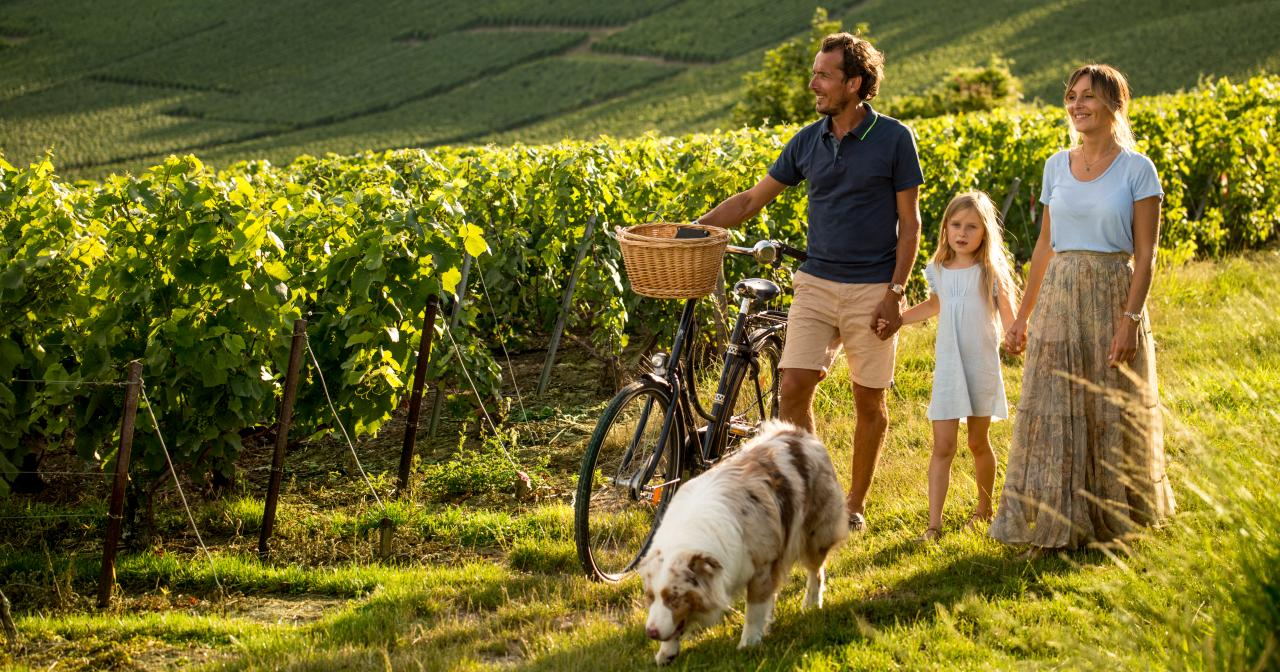

In [ ]:
img_pil = Image.open('/content/vignoble_-_reims_-_wwwmkbphotos-coll_adt_marne10.jpg').convert('RGB')
display(img_pil)

In [ ]:
img_tensor = transforms.functional.to_tensor(img_pil)

In [ ]:
list_tensor = [img_tensor.to(device)]

In [ ]:
model.eval()
with tc.no_grad():
  pred = model(list_tensor)

pred

In [ ]:
boxes = pred[0]['boxes'].cpu()
labels = pred[0]['labels'].cpu()
scores = pred[0]['scores'].cpu()

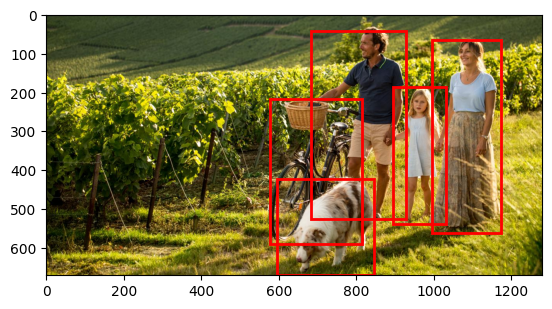

In [ ]:
np_arr = img_tensor.permute(1, 2, 0)
plt.imshow(np_arr)

ax = plt.gca()
for box, label, score in zip(boxes, labels, scores):
  if score>0.5:
    rect = Rectangle((box[0], box[1]),
                     (box[2] - box[0]),
                     (box[3] - box[1]),
                     fill = False,
                     edgecolor = (1, 0, 0),
                     linewidth = 2)
    ax.add_patch(rect)

plt.show()

In [ ]:
!curl -L "https://public.roboflow.com/ds/v6LlMcVad6?key=4EU86tkG97" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [ ]:
from pycocotools.coco import COCO
class CocoDetection(Dataset):

    def __init__(
        self,
        root: str,
        annFile: str,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        transforms: Optional[Callable] = None,
    ) -> None:
        super(CocoDetection, self).__init__()

        self.coco = COCO(annFile)
        self.ids  = list(sorted(self.coco.imgs.keys()))
        self.root = root
        self.transforms = transforms

    def _load_image(self, id: int) -> Image.Image:
        path = self.coco.loadImgs(id)[0]["file_name"]
        return Image.open(os.path.join(self.root, path)).convert("RGB")

    def _load_target(self, id: int) -> List[Any]:
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index: int) -> Tuple[Any, Any]:

        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)

        targets = {}
        targets['boxes'] = tc.tensor([item['bbox'] for item in target])
        targets['labels'] = tc.tensor([item['category_id'] for item in target])

        try:
            if self.transforms is not None:
                image       = tv.transforms.functional.to_tensor(image).permute(1, 2, 0).numpy()
                transformed = self.transforms(image = image, bboxes = targets['boxes'], category_ids = targets['labels'])

            image = tc.tensor(transformed['image']).permute(2, 0, 1)
            targets['boxes'] = tc.tensor(transformed['bboxes'])
            #targets['area'] = targets['boxes'][: ,2] * targets['boxes'][: ,3]
            targets['boxes'][: ,2] += targets['boxes'][: ,0]
            targets['boxes'][: ,3] += targets['boxes'][: ,1]
            targets['labels'] = tc.tensor(transformed['category_ids'])
            #targets['iscrowd'] = tc.tensor([item['iscrowd'] for item in target])
            #targets['image_id'] = tc.tensor(target[0]['image_id'])
        except:
            target = self._load_target(2)
            image = tc.tensor(image)
            if image.shape[0] == 3:
              None
            else:
              image = image.permute(2, 0, 1)
            targets = {}
            targets['boxes'] = tc.tensor([item['bbox'] for item in target])
            targets['labels'] = tc.tensor([item['category_id'] for item in target])
            #targets['image_id'] = tc.tensor(target[0]['image_id'])
            #targets['iscrowd'] = tc.tensor([item['iscrowd'] for item in target])
            #targets['area'] = targets['boxes'][: ,2] * targets['boxes'][: ,3]
            targets['boxes'][: ,2] += targets['boxes'][: ,0]
            targets['boxes'][: ,3] += targets['boxes'][: ,1]

        return image, targets

    def __len__(self) -> int:
        return len(self.ids)


In [ ]:
transform_train = A.Compose([A.HorizontalFlip(p = 0.9),
                            A.ShiftScaleRotate(p = 0.9),
                            A.RandomBrightness(p = 0.3)],
                       bbox_params = A.BboxParams(format = 'coco', label_fields = ['category_ids']))
transform_test = A.Compose([A.Resize(416, 416)],
                       bbox_params = A.BboxParams(format = 'coco', label_fields = ['category_ids']))

In [ ]:
train_dataset = CocoDetection(root = '/content/train/',
                              annFile = '/content/train/_annotations.coco.json', transforms = transform_train)
valid_dataset = CocoDetection(root = '/content/valid/',
                              annFile = '/content/valid/_annotations.coco.json', transforms = transform_test)

In [ ]:
def new_concat(batch):
  return tuple(zip(*batch))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 1, shuffle = False, num_workers = 4, collate_fn = new_concat)
valid_loader = DataLoader(valid_dataset, batch_size = 1, shuffle = False, num_workers = 4, collate_fn = new_concat)

In [ ]:
batch = next(iter(train_loader))

In [ ]:
batch[0][0].shape, batch[1]

In [ ]:
images  = [image.to(device) for image in batch[0]]
targets = [{k: v.to(device) for k, v in t.items()} for t in batch[1]]

In [ ]:
images

In [ ]:
targets

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train_one_epoch(model, train_loader, loss_func, optimizer, shedular, epoch):
    model.train()

    train_loss=AverageMeter()

    with tqdm(train_loader, unit='batch') as tepoch:
        for idx, (images, targets) in enumerate(tepoch):
            if epoch is not None:
                tepoch.set_description(f'Epoch={epoch}')

            optimizer.zero_grad()

            images  = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


            loss_dict = model(images, targets)
            loss      = sum(error for error in loss_dict.values())

            loss.backward()
            optimizer.step()
            shedular.step()

            train_loss.update(loss.item())


            tepoch.set_postfix(loss=train_loss.avg)

    return model, train_loss.avg

In [ ]:
def validation(model, valid_loaedr, loss_func, device):
    model.eval()
    model = model.to(device)

    valid_map = MeanAveragePrecision('xyxy')

    for batch in valid_loaedr:

        images  = [image.to(device) for image in batch[0]]
        targets = [{k: v.to(device) for k, v in t.items()} for t in batch[1]]

        pred = model(images)


        valid_map.update(pred, targets)

    print(f'{valid_map.compute()}')
    print()

    return valid_map

In [ ]:
model = models.detection.retinanet_resnet50_fpn(True)
model = model.to(device)

In [ ]:
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9, weight_decay = 1e-4)
shedular  = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 20000, eta_min = 1e-6)

In [ ]:
start, end = 0, 1
for i in range(start, end):

  model, train_loss = train_one_epoch(model, train_loader, None,  optimizer, shedular, i)
  validation(model,valid_loader, None, 'cpu')

In [ ]:
#customize retinanet

In [ ]:
backbone = tv.models.mobilenet_v2(True).features
backbone.out_channels = 1280

In [ ]:
from torchvision.models.detection.anchor_utils import AnchorGenerator

In [ ]:
anchors = AnchorGenerator(sizes = ((32, 64, 128, 256, 512), ), aspect_ratios = ((0.5, 1, 2), ))

In [ ]:
model = models.detection.RetinaNet(backbone, 200, anchor_generator = anchors, )

In [ ]:
model = model.to(device)

In [ ]:
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9, weight_decay = 1e-4)
shedular  = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 20000, eta_min = 1e-6)

In [ ]:
start, end = 0, 10
for i in range(start, end):

  model, train_loss = train_one_epoch(model, train_loader, None,  optimizer, shedular, i)
  validation(model,valid_loader, None, device)

In [ ]:
#work on backbone

In [ ]:
fpn_resnet18 = tv.models.detection.backbone_utils.resnet_fpn_backbone('resnet18', True)

In [ ]:
print([(k, v.shape) for k, v in fpn_resnet18(tc.randn(1, 3, 224, 224)).items()])

In [ ]:
from torchvision.models.detection.backbone_utils import BackboneWithFPN

In [ ]:
class FPNMobileNet(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        net = models.mobilenet_v2(pretrained)
        features = net.features
        self.layer1= nn.Sequential(*features[0:4])
        self.layer2 = nn.Sequential(*features[4:7])
        self.layer3 = nn.Sequential(*features[7:11])
        self.layer4 = nn.Sequential(*features[11:19])
        for param in features.parameters():
            param.requires_grad = False

    def forward(self, x):

        # Bottom-up pathway, from ResNet
        enc0 = self.layer1(x) # 24
        enc1 = self.layer2(enc0) # 32
        enc2 = self.layer3(enc1) # 64
        enc3 = self.layer4(enc2) # 1280
        return enc3


def mobilenet_fpn_backbone(pretrained):
    backbone = FPNMobileNet(pretrained)
    # freeze layers
    for name, parameter in backbone.named_parameters():
        if 'layer2' not in name and 'layer3' not in name and 'layer4' not in name:
            parameter.requires_grad_(False)

    return_layers = {'layer1': 0, 'layer2': 1, 'layer3': 2, 'layer4': 3}

    in_channels_list = [
       24, 32, 64, 1280
    ]

    out_channels = 256
    return BackboneWithFPN(backbone, return_layers, in_channels_list, out_channels)

In [ ]:
backbone = mobilenet_fpn_backbone(True)

In [ ]:
print([(k, v.shape) for k, v in backbone(tc.randn(1, 3, 224, 224)).items()])

In [ ]:
from torchvision.models._utils import IntermediateLayerGetter

In [ ]:
backbone = models.mobilenet_v2(True).features.children
backbone

In [ ]:
return_layers = {'4': 0, '7': 1, '11': 2, '19': 3}

In [ ]:
IntermediateLayerGetter(backbone, return_layers = return_layers)

In [ ]:
backbone = FPNMobileNet(True)
return_layers = {'layer1': 0, 'layer2': 1, 'layer3': 2, 'layer4': 3}

In [ ]:
m = IntermediateLayerGetter(backbone, return_layers = return_layers)

In [ ]:
output = m(tc.randn(1, 3, 224, 224))

In [ ]:
print([(k, v.shape) for k, v in output.items()])

In [ ]:
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork

In [ ]:
fpn = FeaturePyramidNetwork([24, 32, 64, 1280], 512)

In [ ]:
fpn

In [ ]:
output2 = fpn(output)

In [ ]:
print([(k, v.shape) for k, v in output2.items()])

In [ ]:
fpn2 = FeaturePyramidNetwork([512, 512, 512, 512], 1024)

In [ ]:
output3 = fpn2(output2)

In [ ]:
print([(k, v.shape) for k, v in output3.items()])